Import Libraries

In [1]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve

Preprocess Function

In [2]:
# Load dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

def svm_preprocessing(df):
    df = df.drop('customerID', axis=1)

    # Handle missing values
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

    # Feature engineering
    df['AvgMonthlyImpact'] = (df['TotalCharges'] / (df['tenure'] + 1e-6)) - df['MonthlyCharges']
    df['ServiceDiversity'] = df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                               'TechSupport', 'StreamingTV', 'StreamingMovies']].apply(lambda x: x.nunique(), axis=1)

    # Standardize categorical service features
    service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies']
    for col in service_cols:
        df[col] = df[col].replace({'No internet service': 'No'})

    # Convert target variable
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

    return df

preprocess data

In [3]:
df = svm_preprocessing(df)

# Split data
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocessing pipeline
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlyImpact', 'ServiceDiversity']
categorical_features = ['InternetService', 'Contract', 'PaymentMethod', 'TechSupport', 'OnlineSecurity']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

Apply preprocessing and run the model

In [4]:
# SVM pipeline with hyperparameter tuning
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(class_weight='balanced', probability=True, random_state=42))
])

param_grid = {
    'classifier__C': [0.5, 1, 5, 10],
    'classifier__kernel': ['rbf', 'sigmoid'],
    'classifier__gamma': ['scale', 'auto', 0.1, 0.5],
    'classifier__coef0': [0, 0.5, 1]  # Only for sigmoid kernel
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters: {'classifier__C': 0.5, 'classifier__coef0': 0, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}
Test Accuracy: 0.7232
ROC-AUC Score: 0.8253

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1035
           1       0.49      0.79      0.60       374

    accuracy                           0.72      1409
   macro avg       0.69      0.74      0.70      1409
weighted avg       0.79      0.72      0.74      1409



Model evalution

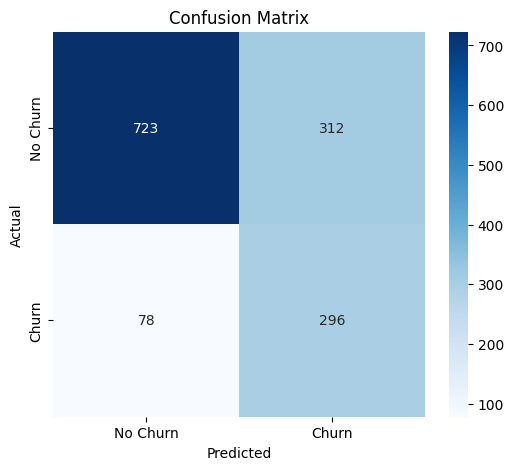

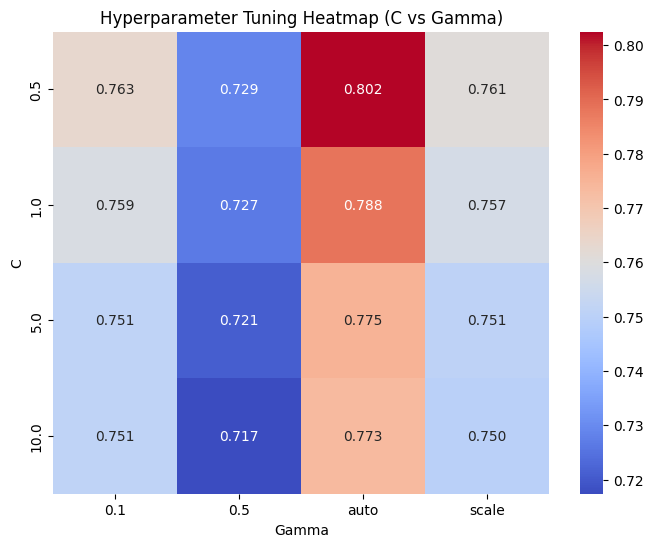

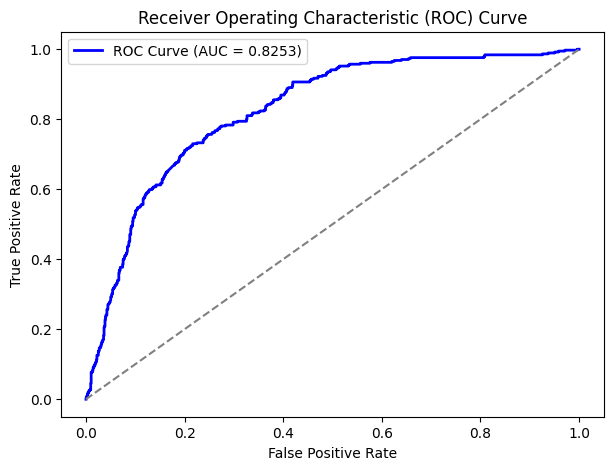

Model saved successfully!


In [10]:
# 🔹 Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 🔹 Feature Importance (Only for Linear Kernel)
if best_model.named_steps['classifier'].kernel == 'linear':
    feature_names = numeric_features + list(best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
    importances = best_model.named_steps['classifier'].coef_[0]

    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance = feature_importance.sort_values(by='Importance', key=abs, ascending=False)

    print("\nTop 10 Features:")
    print(feature_importance.head(10))

    # 🔹 Feature Importance Plot
    plt.figure(figsize=(10,5))
    sns.barplot(x=feature_importance['Importance'].head(10), y=feature_importance['Feature'].head(10), palette='viridis')
    plt.title("Top 10 Important Features")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

# 🔹 Hyperparameter Tuning Heatmap
cv_results = pd.DataFrame(grid_search.cv_results_)
pivot = cv_results.pivot_table(index='param_classifier__C', columns='param_classifier__gamma', values='mean_test_score', aggfunc='mean')

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="coolwarm")
plt.title("Hyperparameter Tuning Heatmap (C vs Gamma)")
plt.xlabel("Gamma") # Adjust label accordingly
plt.ylabel("C")
plt.show()

# 🔹 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

# 🔹 Save Model
joblib.dump(best_model, "svm_churn_model.pkl")
print("Model saved successfully!")

# Test Model with real data

In [14]:


# Create synthetic data
test_data = pd.read_csv('synthetic_svm_test_data.csv')

# Save for use if needed
test_data.to_csv('synthetic_test_data.csv', index=False)
print("Synthetic test dataset created!")


Synthetic test dataset created!


In [15]:
# Load saved model
model = joblib.load("svm_churn_model.pkl")

# Predict churn probabilities
predictions = model.predict(test_data)
proba = model.predict_proba(test_data)[:, 1]

# Display results
for i, (p, prob) in enumerate(zip(predictions, proba)):
    print(f"Customer {i+1}: Churn = {p} | Probability = {prob:.4f}")

Customer 1: Churn = 0 | Probability = 0.1127
Customer 2: Churn = 0 | Probability = 0.0503
Customer 3: Churn = 1 | Probability = 0.3185
Customer 4: Churn = 0 | Probability = 0.0717
Customer 5: Churn = 1 | Probability = 0.3378
Customer 6: Churn = 1 | Probability = 0.3906
Customer 7: Churn = 0 | Probability = 0.1605
Customer 8: Churn = 0 | Probability = 0.0461
Customer 9: Churn = 0 | Probability = 0.0483
Customer 10: Churn = 0 | Probability = 0.2368
Customer 11: Churn = 0 | Probability = 0.0419
Customer 12: Churn = 0 | Probability = 0.0501
Customer 13: Churn = 0 | Probability = 0.0567
Customer 14: Churn = 0 | Probability = 0.0975
Customer 15: Churn = 1 | Probability = 0.2576
Customer 16: Churn = 0 | Probability = 0.1086
Customer 17: Churn = 1 | Probability = 0.5723
Customer 18: Churn = 0 | Probability = 0.0718
Customer 19: Churn = 0 | Probability = 0.0394
Customer 20: Churn = 0 | Probability = 0.0613
Customer 21: Churn = 0 | Probability = 0.0524
Customer 22: Churn = 0 | Probability = 0.14